In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

root_dir = "../../"
sys.path.append(root_dir)
from configs import get_config
from classifiers import get_classifier
from datasets import get_dataset
from notebooks.utils import viz_explanation

config_name = "chexpert_topic"
doctor_config_dict = {
    "data.explanation_length": 12,
    "listener.type": "topic",
    "listener.gamma": 0.4,
    "listener.prior": [1.00, 0.00],
    "listener.temperature_scale": [4.0],
    "speaker.alpha": 0.2,
}
doctor_config = get_config(config_name, config_dict=doctor_config_dict)
doctor_prior = np.array(doctor_config.listener.prior)
doctor_config = get_config(config_name, config_dict=doctor_config_dict)
doctor_prior = np.array(doctor_config.listener.prior)
doctor_results = [
    c.get_results() for c in doctor_config.sweep(["listener.temperature_scale"])
]

patient_config_dict = {
    "data.explanation_length": 12,
    "listener.type": "topic",
    "listener.gamma": 0.4,
    # "listener.prior": 6 * [1 / 6],
    "listener.prior": [0.00, 1.00],
    "listener.temperature_scale": [4.0],
    "speaker.alpha": 0.2,
}
patient_config = get_config(config_name, config_dict=patient_config_dict)
patient_prior = np.array(patient_config.listener.prior)
patient_results = [
    c.get_results() for c in patient_config.sweep(["listener.temperature_scale"])
]

# no_preference_config_dict = {
#     "data.explanation_length": 12,
#     "listener.type": "claim",
#     "listener.gamma": 0.4,
#     "speaker.alpha": 0.2,
# }
# no_preference_config = get_config(config_name, config_dict=no_preference_config_dict)
# no_preference_results = [
#     c.get_results() for c in no_preference_config.sweep(["listener.temperature_scale"])
# ]

classifier = get_classifier(doctor_config, device="cpu")
dataset = get_dataset(
    doctor_config, train=False, transform=classifier.preprocess, return_attribute=True
)
classes = dataset.classes

topics = ['doctor preferred', 'patient preferred']
sns.set_theme()
sns.set_context("paper")

/cis/home/zwang/Projects/pragmatixs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cis/home/zwang/Projects/pragmatixs/.venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'CXRBertTokenizer'.
You are using a model of type bert to instantiate a model of type cxr-bert. This is not supported for all configurations of mode

90.17%
91.03%


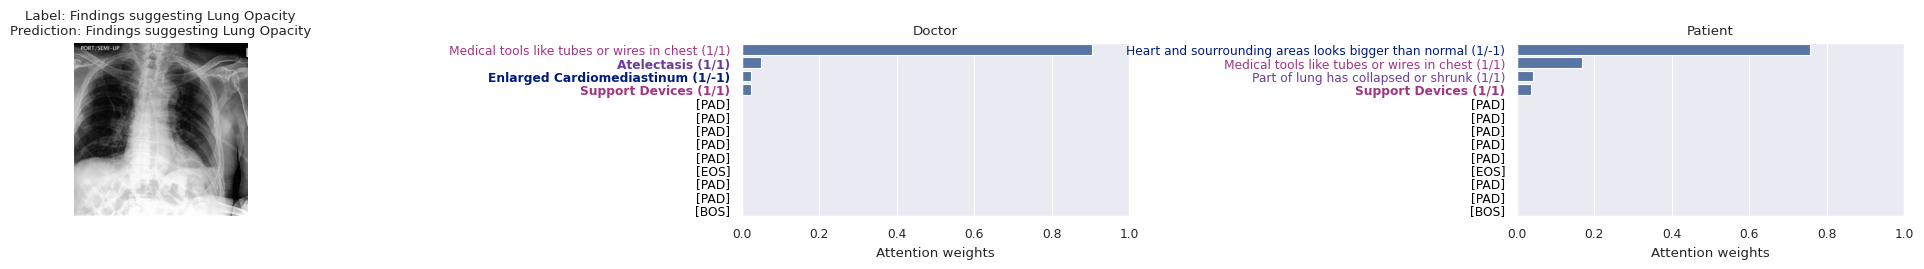

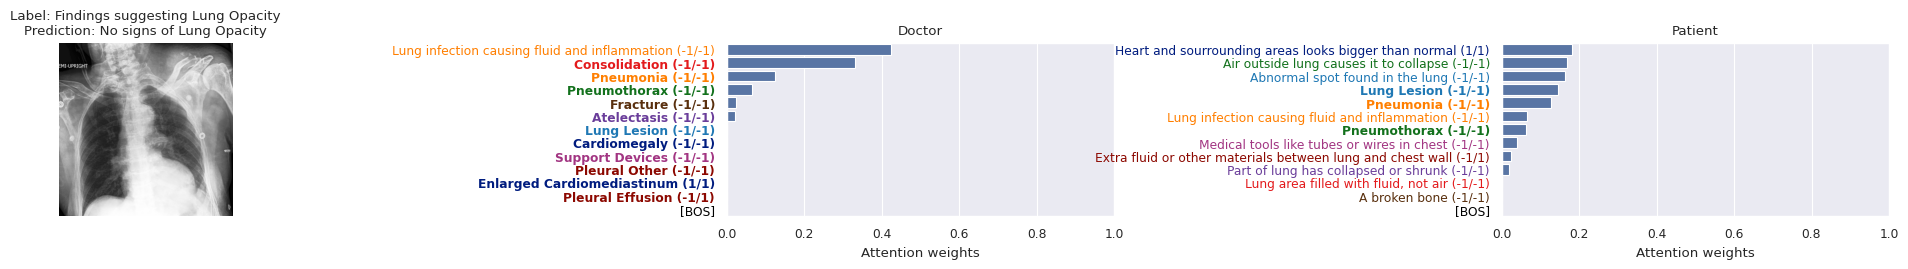

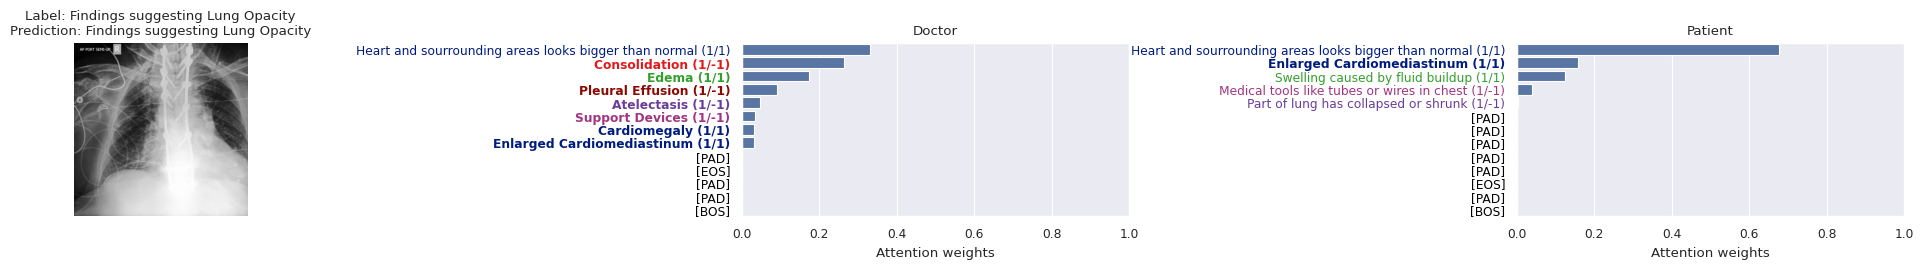

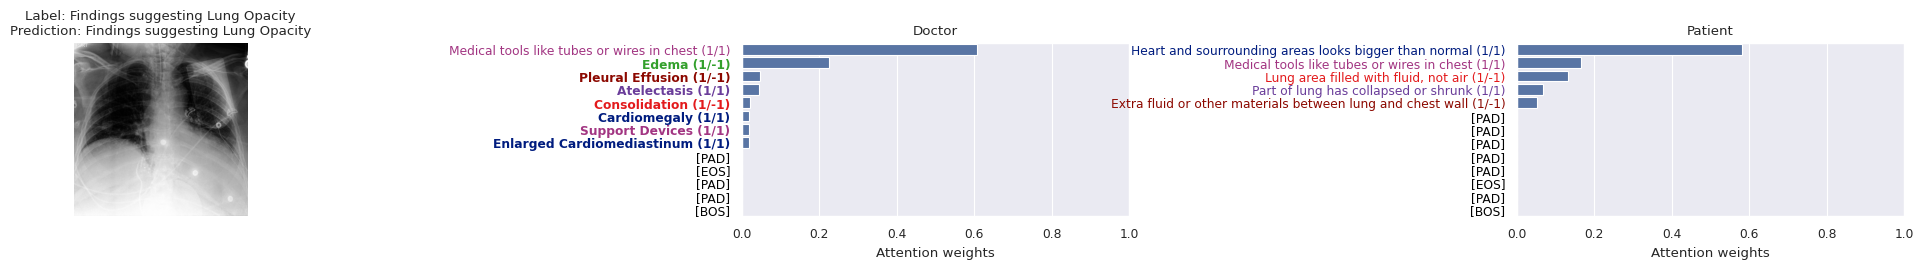

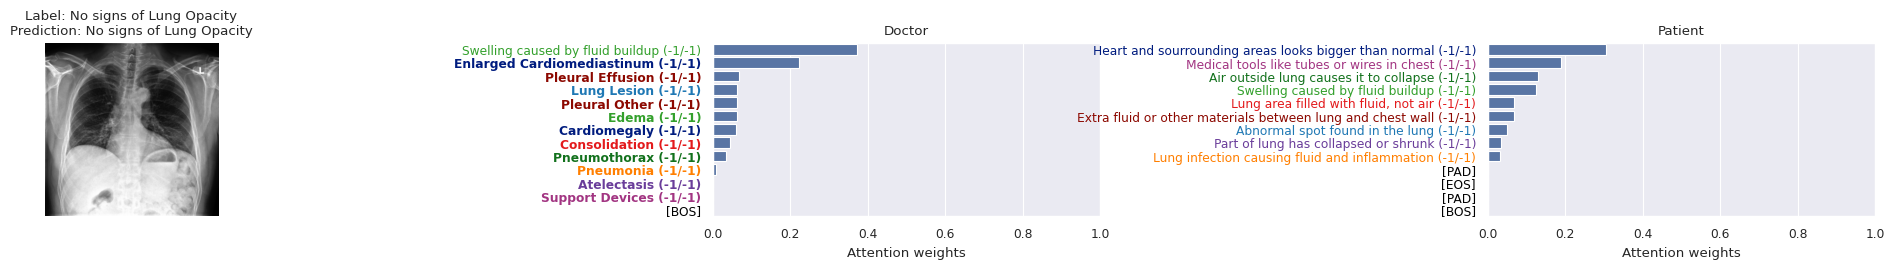

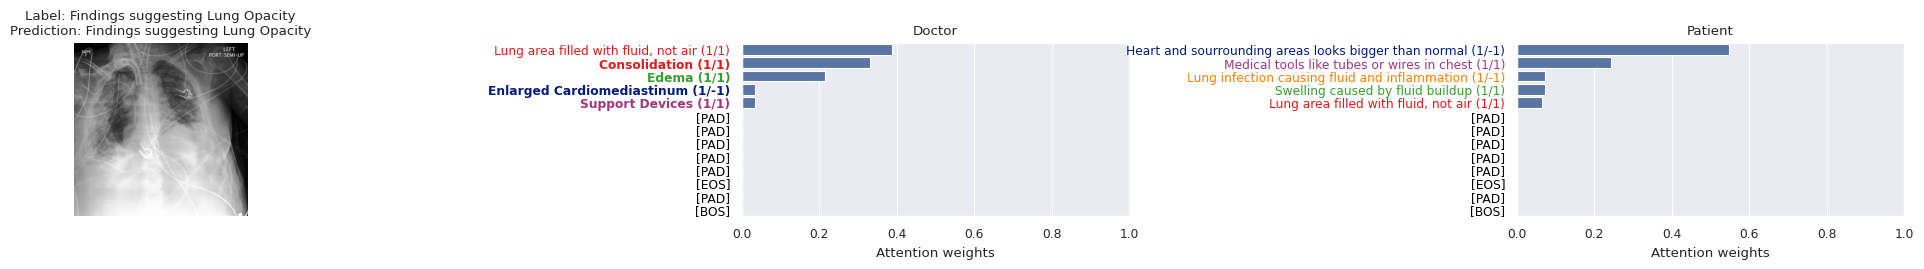

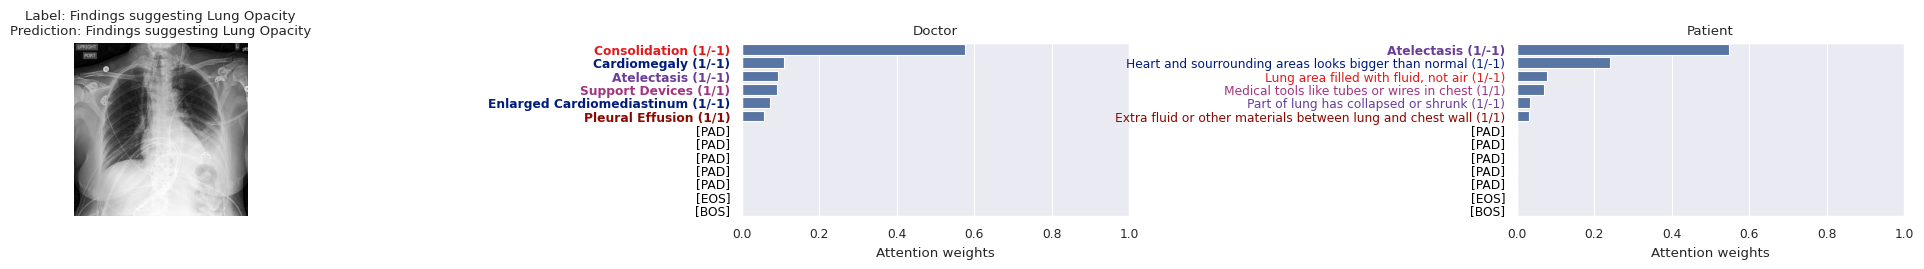

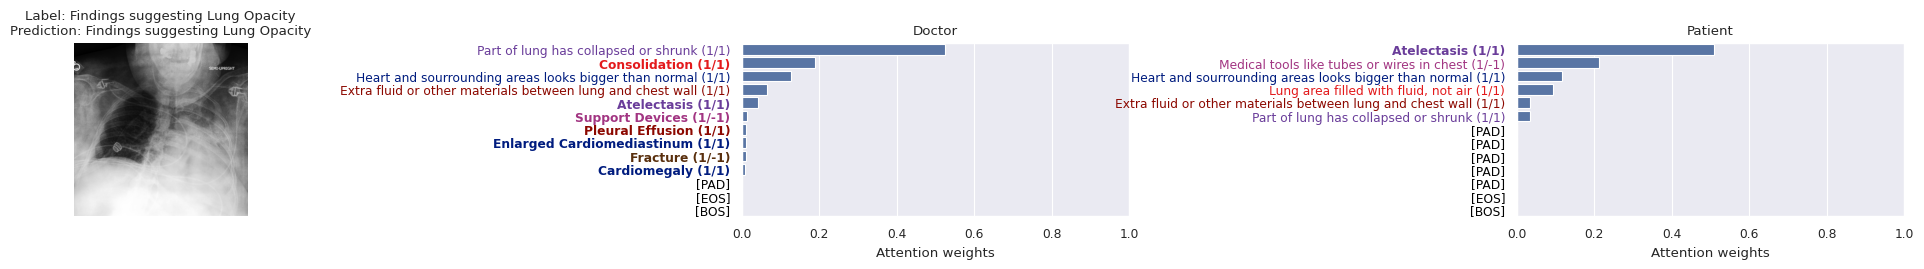

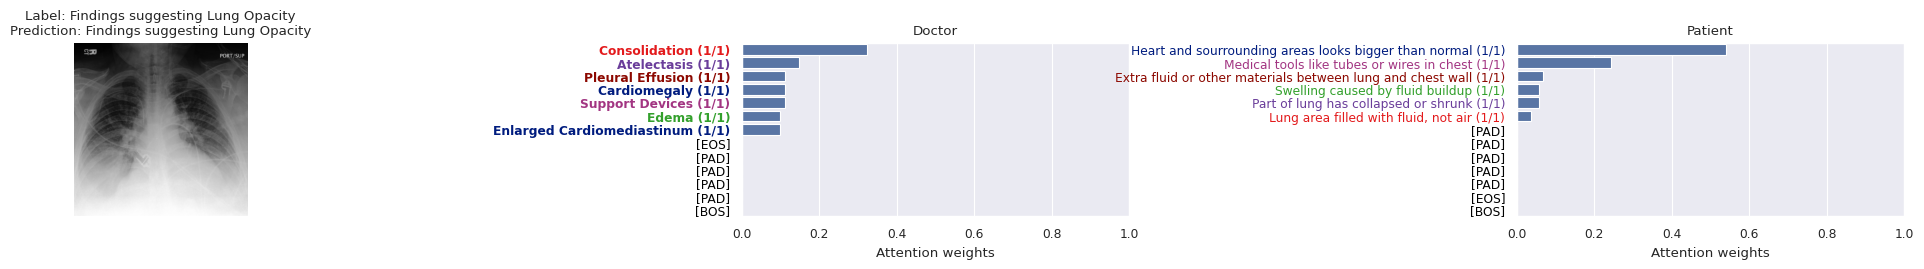

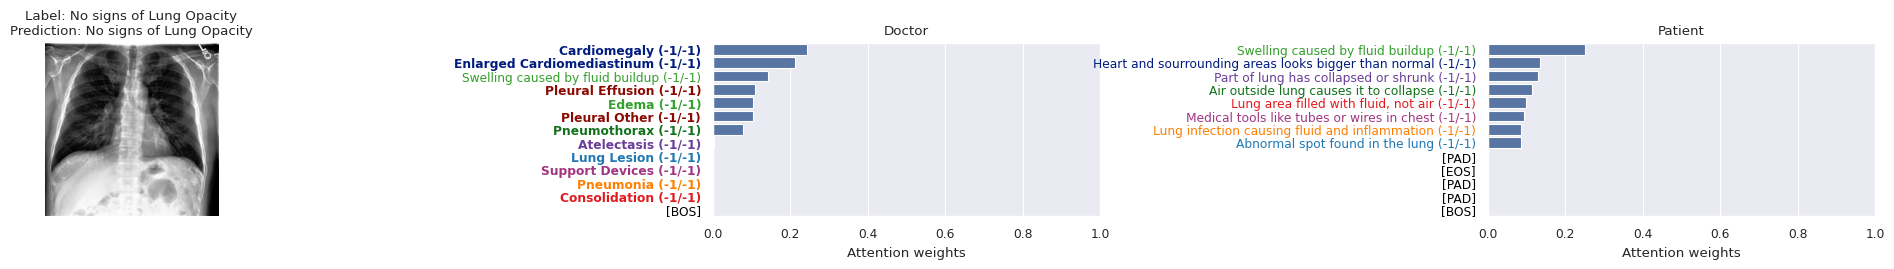

In [5]:

Color_map ={
    'Enlarged Cardiomediastinum': sns.color_palette("dark")[0],
    'Cardiomegaly': sns.color_palette("dark")[0],
    'Heart and sourrounding areas looks bigger than normal':sns.color_palette("dark")[0],

    
    'Lung Lesion':sns.color_palette("Paired")[1],
    'Abnormal spot found in the lung':sns.color_palette("Paired")[1],
    
    'Edema': sns.color_palette("Paired")[3],
    'Swelling caused by fluid buildup': sns.color_palette("Paired")[3],
    
    'Consolidation': sns.color_palette("Paired")[5],
    'Lung area filled with fluid, not air': sns.color_palette("Paired")[5],
    
    'Pneumonia': sns.color_palette("Paired")[7],
    'Lung infection causing fluid and inflammation': sns.color_palette("Paired")[7],
    
    'Atelectasis': sns.color_palette("Paired")[9],
    'Part of lung has collapsed or shrunk': sns.color_palette("Paired")[9],
    
    'Pneumothorax': sns.color_palette("dark")[2],
    'Air outside lung causes it to collapse': sns.color_palette("dark")[2],
    
    'Pleural Effusion': sns.color_palette("dark")[3],
    'Pleural Other':sns.color_palette("dark")[3],
    'Extra fluid or other materials between lung and chest wall':sns.color_palette("dark")[3],
    
    
    'Fracture': sns.color_palette("dark")[5],
    'A broken bone': sns.color_palette("dark")[5],
    
    'Support Devices': sns.color_palette("dark")[6],
    'Medical tools like tubes or wires in chest': sns.color_palette("dark")[6],
    '[BOS]':'black',
    '[EOS]':'black',
    '[PAD]':'black',

}
_doctor_results = doctor_results[0]
_patient_results = patient_results[0]
# _no_preference_results = no_preference_results[1]


for r in [
    _doctor_results,
    _patient_results,
    # _no_preference_results,
]:
    r["listener_prediction"] = r["action"].apply(lambda x: np.argmax(x))
    r["correct"] = r["prediction"] == r["listener_prediction"]
    print(f"{r['correct'].mean():.2%}")
mask = (_doctor_results["listener_prediction"] == _doctor_results["label"]).values

# _prag_topic_kl = prag_topic_kl[best_temperature_idx]
# kl_diff = prag_claim_kl - _prag_topic_kl
# sorted_idx = np.argsort(kl_diff)[::-1]
# sorted_mask = mask[sorted_idx]
# sorted_idx = sorted_idx[sorted_mask]
def viz_explanation(dataset, results, idx, ax):
    _, _, image_attribute = dataset[idx]

    classes = dataset.classes
    claims = dataset.claims

    vocab_size = len(claims) + 3
    special_tokens = {
        vocab_size - 3: "[BOS]",
        vocab_size - 2: "[EOS]",
        vocab_size - 1: "[PAD]",
    }

    idx_results = results.iloc[idx]
    explanation = idx_results["explanation"]
    cls_attn_weights = idx_results["cls_attention"]
    cls_attn_weights = cls_attn_weights[:-1]
    cls_attn_weights /= np.sum(cls_attn_weights)

    image_attribute[image_attribute == -1] = 0
    image_attribute = image_attribute * 2 - 1
    explanation_claims = [
        (
            f"{claims[claim]} ({cls*2-1}/{image_attribute[claim]:.0f})"
            if claim < len(claims)
            else special_tokens[claim]
        )
        for claim, cls in explanation
    ]
    explanation_claims = explanation_claims

    y = list(map(str, range(len(explanation_claims))))
    
    # sort the claims by their attention weights
    sorted_idx = np.argsort(cls_attn_weights)[::-1]
    cls_attn_weights = cls_attn_weights[sorted_idx]
    explanation_claims = [explanation_claims[i] for i in sorted_idx]
    y = [y[i] for i in sorted_idx]
    
    sns.barplot(x=cls_attn_weights, y=y, ax=ax)
    ax.set_xlabel("Attention weights")
    ax.set_yticks(y)
    ax.set_yticklabels(explanation_claims)
    # set different color for special tokens in yticklabels
    
    for i, claim in enumerate(explanation_claims):
        if " (" in claim:
            claim = claim.split(" (")[0]
        ax.get_yticklabels()[i].set_color(Color_map[claim])
        if claim in [
                'Enlarged Cardiomediastinum',
                'Lung Opacity',
                'Cardiomegaly',
                'Lung Lesion',
                'Edema',
                'Consolidation',
                'Pneumonia',
                'Atelectasis',
                'Pneumothorax',
                'Pleural Effusion',
                'Pleural Other',
                'Fracture',
                'Support Devices'
            ]:
            # bold the text
            ax.get_yticklabels()[i].set_weight("bold")
  
    ax.set_title(f"Listener prediction:\n{classes[idx_results['listener_prediction']]}")


import random
m = 10
indices = random.sample(np.where(mask)[0].tolist(), m)
for _idx in indices:
    image, label, image_attribute = dataset[_idx]

    # idx_lit_claim_results = lit_claim_results.iloc[_idx]
    # idx_prag_claim_results = prag_claim_results.iloc[_idx]
    idx_doctor_results = _doctor_results.iloc[_idx]
    idx_patient_results = _patient_results.iloc[_idx]
    assert idx_doctor_results["prediction"] == idx_patient_results["prediction"]
    cls_prediction = idx_patient_results["prediction"]

    # image = (image * 1 / 2) + 1 / 2

    _, axes = plt.subplots(
        1,
        3,
        figsize=(25, 9 / 4),
        gridspec_kw={"width_ratios": [1, 1, 1], "wspace": 1.0},
    )
    ax = axes[0]
    ax.imshow(image.permute(1, 2, 0))
    ax.axis("off")
    ax.set_title(f"Label: {classes[int(label)]}\nPrediction: {classes[cls_prediction]}")
    


    ax = axes[1]
    viz_explanation(dataset, _doctor_results, _idx, ax)
    ax.set_title("Doctor")
    ax.set(xlim = (0, 1))

    ax = axes[2]
    viz_explanation(dataset, _patient_results, _idx, ax)
    ax.set_title("Patient")
    ax.set(xlim = (0, 1))
    
    # ax = axes[3]
    # viz_explanation(dataset, _no_preference_results, _idx, ax)
    # ax.set_title("No Preference")
    # ax.set(xlim = (0, 1))

    plt.show()



In [ ]:
p_patient_results = np.stack(_patient_results['explanation_topics'].to_list(), axis = 0)
p_doctor_results = np.stack(_doctor_results['explanation_topics'].to_list(), axis = 0)
p_no_preference = np.stack(_no_preference_results['explanation_topics'].to_list(), axis = 0)
# boxplot


fig, ax_ = plt.subplots(1, 3, figsize=(8, 3), sharey=True)
ax = ax_[0]
p1, p2 = p_patient_results[:, 0], p_patient_results[:, 1]
sns.boxplot(data=[p1, p2], ax=ax)
ax.set_xticklabels(["Doctor", "Patient"])
ax.set_ylabel("Topic Probability")
ax.set_title("Patient preferred Model")

ax = ax_[1]
p1, p2 = p_doctor_results[:, 0], p_doctor_results[:, 1]
sns.boxplot(data=[p1, p2], ax=ax)
ax.set_xticklabels(["Doctor", "Patient"])
ax.set_ylabel("Topic Probability")
ax.set_title("Doctor preferred Model")


ax = ax_[2]
p1, p2 = p_no_preference[:, 0], p_no_preference[:, 1]
sns.boxplot(data=[p1, p2], ax=ax)
ax.set_xticklabels(["Doctor", "Patient"])
ax.set_ylabel("Topic Probability")
ax.set_title("Model with No Preference")

plt.tight_layout()


In [ ]:
figure_dir = os.path.join(
    root_dir, "figures", topic_config.data.dataset.lower(), "topic_kl"
)
os.makedirs(figure_dir, exist_ok=True)


def topic_kl(results):
    explanation_topics = np.array(results["explanation_topics"].values.tolist())

    return np.sum(
        explanation_topics * np.log((explanation_topics + 1e-08) / (prior + 1e-08)),
        axis=-1,
    )


lit_topic_kl = [topic_kl(r) for r in lit_topic_results]
prag_topic_kl = [topic_kl(r) for r in prag_topic_results]

lit_claim_kl = topic_kl(lit_claim_results)
prag_claim_kl = topic_kl(prag_claim_results)

mu_lit_topic_kl = np.mean(lit_topic_kl, axis=-1).tolist()
mu_prag_topic_kl = np.mean(prag_topic_kl, axis=-1).tolist()

# mu_lit_claim_kl = np.mean(lit_claim_kl)
# mu_prag_claim_kl = np.mean(prag_claim_kl)

_, ax = plt.subplots(figsize=(16 / 4, 9 / 4))
ax.plot(
    [0] + lit_topic_configs.listener.temperature_scale,
    [mu_lit_claim_kl] + mu_lit_topic_kl,
    label="Literal",
    marker="o",
)
ax.plot(
    [0] + prag_topic_configs.listener.temperature_scale,
    [mu_prag_claim_kl] + mu_prag_topic_kl,
    label="Pragmatic",
    marker="o",
)
ax.set_xlabel("Temperature scale")
ax.set_ylabel("Topic KL divergence")
ax.set_xticks([0] + lit_topic_configs.listener.temperature_scale)
ax.legend(title="speaker", loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig(
    os.path.join(
        figure_dir,
        f"temperature_{','.join(map(lambda x: f'{x:.2f}', prag_topic_configs.listener.prior))}.pdf",
    ),
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(
        figure_dir,
        f"temperature_{','.join(map(lambda x: f'{x:.2f}', prag_topic_configs.listener.prior))}.png",
    ),
    bbox_inches="tight",
)
plt.show()

In [ ]:
best_temperature_idx = np.argmin(mu_prag_topic_kl)
best_temperature = prag_topic_configs.listener.temperature_scale[best_temperature_idx]
print(best_temperature_idx, best_temperature)


# best_temperature_idx = 4.0
_lit_topic_results = lit_topic_results[best_temperature_idx]
_prag_topic_results = prag_topic_results[best_temperature_idx]
for r in [
    _lit_topic_results,
    _prag_topic_results,
    lit_claim_results,
    prag_claim_results,
]:
    r["listener_prediction"] = r["action"].apply(lambda x: np.argmax(x))
    r["correct"] = r["prediction"] == r["listener_prediction"]
    print(f"{r['correct'].mean():.2%}")

mask = (_prag_topic_results["correct"] & prag_claim_results["correct"]).values

_prag_topic_kl = prag_topic_kl[best_temperature_idx]
kl_diff = prag_claim_kl - _prag_topic_kl
sorted_idx = np.argsort(kl_diff)[::-1]
sorted_mask = mask[sorted_idx]
sorted_idx = sorted_idx[sorted_mask]

In [ ]:
figure_dir = os.path.join(
    root_dir,
    "figures",
    prag_topic_configs.sweep(["listener.temperature_scale"])[
        best_temperature_idx
    ].run_name(),
)
os.makedirs(figure_dir, exist_ok=True)

m = 10
for _idx in sorted_idx[:m]:
    image, label, image_attribute = dataset[_idx]

    # idx_lit_claim_results = lit_claim_results.iloc[_idx]
    # idx_prag_claim_results = prag_claim_results.iloc[_idx]
    idx_lit_claim_results = _lit_claim_results.iloc[_idx]
    idx_prag_topic_results = _prag_topic_results.iloc[_idx]
    assert idx_prag_claim_results["prediction"] == idx_prag_topic_results["prediction"]
    cls_prediction = idx_prag_claim_results["prediction"]

    image = (image * 1 / 2) + 1 / 2

    _, axes = plt.subplots(
        1,
        4,
        figsize=(30, 9 / 4),
        gridspec_kw={"width_ratios": [3, 1, 1, 1], "wspace": 1.0},
    )
    ax = axes[0]
    ax.imshow(image.permute(1, 2, 0))
    ax.axis("off")
    ax.set_title(f"Label: {classes[int(label)]}\nPrediction: {classes[cls_prediction]}")

    # ax = axes[1]
    # viz_explanation(dataset, lit_claim_results, _idx, ax)

    ax = axes[2]
    viz_explanation(dataset, _lit_topic_results, _idx, ax)

    ax = axes[3]
    viz_explanation(dataset, _prag_topic_results, _idx, ax)
    plt.savefig(
        os.path.join(figure_dir, f"{_idx}_explanations.pdf"), bbox_inches="tight"
    )
    plt.savefig(
        os.path.join(figure_dir, f"{_idx}_explanations.png"), bbox_inches="tight"
    )
    plt.show()

    topic_data = {"topic": [], "probability": [], "speaker": []}
    for speaker, speaker_results in [
        ("Literal/none", idx_lit_claim_results),
        ("Pragmatic/Literal", idx_prag_claim_results),
        ("Pragmatic/Topic", idx_prag_topic_results),
    ]:
        explanation_topics = speaker_results["explanation_topics"]
        for i, topic in enumerate(topics):
            topic_data["topic"].append(topic)
            topic_data["probability"].append(explanation_topics[i])
            topic_data["speaker"].append(speaker)
    for i, topic in enumerate(topics):
        topic_data["topic"].append(topic)
        topic_data["probability"].append(prior[i])
        topic_data["speaker"].append("Topic prior")

    _, ax = plt.subplots(figsize=(9 / 8, 16 / 8))
    topic_df = pd.DataFrame(topic_data)
    sns.barplot(data=topic_data, y="topic", x="probability", hue="speaker", ax=ax)
    ax.set_xlabel("Frequency")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.legend(title="Speaker/Listener", loc="upper left", bbox_to_anchor=(1, 1))
    plt.savefig(os.path.join(figure_dir, f"{_idx}_topics.pdf"), bbox_inches="tight")
    plt.savefig(os.path.join(figure_dir, f"{_idx}_topics.png"), bbox_inches="tight")
    plt.show()